In [11]:
# Celula 1 - Objetivo: preparar imports, paths e validacoes iniciais.
from pathlib import Path
import json
from datetime import date

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

repo_root = Path("/home/wilson/PortfolioZero")
lab_root = repo_root / "0_desenvolvimentos/lab_experimentos/fase1_vendas"

spec_path = lab_root / "configs/SPEC_FROZEN_MIRROR_V1.json"
ruleset_path = lab_root / "configs/rulesets/SELL_RULESET_02.json"
prices_dir = repo_root / "data/raw/market/prices"
universe_supervised_path = repo_root / "data/universe/supervised_TASK_A_012/UNIVERSE_SUPERVISED.parquet"
run_prop2_dir = lab_root / "outputs/sweep_5_rulesets_v2/SELL_RULESET_02"
orders_path = run_prop2_dir / "orders/orders.csv"

out_dir = lab_root / "outputs/prop2_q1_2023_inspecao"
out_dir.mkdir(parents=True, exist_ok=True)

assert spec_path.exists(), f"Spec nao encontrada: {spec_path}"
assert ruleset_path.exists(), f"Ruleset nao encontrado: {ruleset_path}"
assert prices_dir.exists(), f"Pasta de precos nao encontrada: {prices_dir}"
assert universe_supervised_path.exists(), f"Universe supervised nao encontrado: {universe_supervised_path}"
if not run_prop2_dir.exists():
    print(f"Aviso: run_prop2_dir nao encontrado, fallback para universo: {run_prop2_dir}")


In [3]:
# Celula 2 - Objetivo: carregar spec/ruleset e exibir resumo minimo.
spec = json.loads(spec_path.read_text(encoding="utf-8"))
ruleset = json.loads(ruleset_path.read_text(encoding="utf-8"))

horizon = spec.get("experiment_horizon", {})
portfolio = spec.get("portfolio", {})
data_contracts = spec.get("data_contracts", {})

metrics_in_ruleset = []
for block_name in ("soft_stop", "hard_stop"):
    block = ruleset.get(block_name, {})
    for cond in block.get("all_of", []):
        metric = cond.get("metric")
        if metric and metric not in metrics_in_ruleset:
            metrics_in_ruleset.append(metric)

print("Resumo spec:")
print(f"- history_warmup_start: {horizon.get('history_warmup_start')}")
print(f"- d0_policy: {horizon.get('d0_policy')}")
print(f"- initial_capital_brl: {portfolio.get('initial_capital_brl')}")
print(f"- target_positions: {portfolio.get('target_positions')}")

print("\nResumo ruleset:")
print(f"- ruleset_id: {ruleset.get('ruleset_id')}")
print(f"- metrics usadas: {metrics_in_ruleset}")
print(f"- soft_stop: {ruleset.get('soft_stop')}")
print(f"- hard_stop: {ruleset.get('hard_stop')}")


Resumo spec:
- history_warmup_start: 2022-01-01
- d0_policy: first_trading_day_of_2023
- initial_capital_brl: 500000.0
- target_positions: 10

Resumo ruleset:
- ruleset_id: SELL_RULESET_02
- metrics usadas: ['vol_60d_over_vol_252d', 'drawdown_20d', 'drawdown_60d']
- soft_stop: {'all_of': [{'metric': 'vol_60d_over_vol_252d', 'op': '>=', 'value': 1.6}, {'metric': 'drawdown_20d', 'op': '>=', 'value': 0.06}], 'action': 'REDUCE'}
- hard_stop: {'all_of': [{'metric': 'vol_60d_over_vol_252d', 'op': '>=', 'value': 1.8}, {'metric': 'drawdown_60d', 'op': '>=', 'value': 0.12}], 'action': 'ZERO'}


In [6]:
# Celula 3 - Objetivo: definir utilitarios e determinar D0 via calendario.
def load_manifest(prices_dir: Path) -> dict:
    manifest_path = prices_dir / "manifest_prices.json"
    if not manifest_path.exists():
        return {}
    return json.loads(manifest_path.read_text(encoding="utf-8")).get("entries", {})


def pick_price_file(ticker: str, prices_dir: Path, manifest: dict) -> Path | None:
    if ticker in manifest:
        manifest_path = Path(manifest[ticker]["file"])
        if manifest_path.exists():
            return manifest_path
    candidates = [
        ticker,
        ticker.replace(".", "_"),
        ticker.replace(".SA", ""),
        ticker.replace(".SA", "_SA"),
    ]
    for name in candidates:
        candidate = prices_dir / f"{name}.parquet"
        if candidate.exists():
            return candidate
    return None


def load_price_series(ticker: str, prices_dir: Path, manifest: dict) -> pd.Series:
    path = pick_price_file(ticker, prices_dir, manifest)
    if not path or not path.exists():
        raise FileNotFoundError(f"Preco nao encontrado para {ticker}")
    df = pd.read_parquet(path, columns=["date", "close"])
    df["date"] = pd.to_datetime(df["date"]).dt.date
    return df.set_index("date")["close"].sort_index()


manifest = load_manifest(prices_dir)

ibov_ticker = data_contracts.get("ibov_ticker", "_BVSP")
calendar_source = None
calendar_series = None
if ibov_ticker:
    try:
        calendar_series = load_price_series(ibov_ticker, prices_dir, manifest)
        calendar_source = ibov_ticker
    except Exception:
        calendar_series = None

if calendar_series is None:
    supervised_df = pd.read_parquet(universe_supervised_path, columns=["ticker"])
    supervised_tickers = sorted(supervised_df["ticker"].dropna().unique().tolist())
    fallback_ticker = supervised_tickers[0]
    calendar_series = load_price_series(fallback_ticker, prices_dir, manifest)
    calendar_source = fallback_ticker

trading_dates = sorted(calendar_series.index)
d0 = next(d for d in trading_dates if d >= date(2023, 1, 1))

print(f"Calendario usado: {calendar_source}")
print(f"D0 (primeiro pregao 2023): {d0.isoformat()}")

first_week_dates = []
d0_idx = trading_dates.index(d0)
for i in range(5):
    if d0_idx + i < len(trading_dates):
        first_week_dates.append(trading_dates[d0_idx + i])


Calendario usado: ABEV3.SA
D0 (primeiro pregao 2023): 2023-01-02


In [17]:
# Celula 4 - Objetivo: gerar novo orders.csv via ranking (min DD, min vol, max retorno).

# 1) Carregar universo supervised (30 tickers) vigente no D0
supervised_df = pd.read_parquet(universe_supervised_path)

def _pick_universe_30(df: pd.DataFrame, ref_date: date) -> list[str]:
    date_cols = [c for c in df.columns if c in ("date", "asof_date", "ref_date", "effective_date")]
    if date_cols:
        date_col = date_cols[0]
        temp = df.copy()
        temp[date_col] = pd.to_datetime(temp[date_col]).dt.date
        temp = temp[temp[date_col] <= ref_date]
        if not temp.empty:
            ref_used = max(temp[date_col])
            temp = temp[temp[date_col] == ref_used]
    else:
        temp = df
    tickers_all = temp["ticker"].dropna().unique().tolist()
    return sorted(tickers_all)[:30]

universe_30 = _pick_universe_30(supervised_df, d0)
print(f"Universo supervised (30) em {d0}: {universe_30}")

# 2) Calcular metricas de 2022 (as-of D-1)
asof_date = trading_dates[trading_dates.index(d0) - 1]


def load_prices_for_tickers(tickers: list[str], prices_dir: Path, manifest: dict) -> pd.DataFrame:
    frames = []
    for ticker in tickers:
        path = pick_price_file(ticker, prices_dir, manifest)
        if not path or not path.exists():
            raise FileNotFoundError(f"Preco nao encontrado para {ticker}")
        df = pd.read_parquet(path, columns=["date", "close", "ticker"])
        df["date"] = pd.to_datetime(df["date"]).dt.date
        frames.append(df[["date", "ticker", "close"]])
    combined = pd.concat(frames, ignore_index=True)
    prices_df = combined.pivot(index="date", columns="ticker", values="close").sort_index()
    return prices_df

prices_universe = load_prices_for_tickers(universe_30, prices_dir, manifest)
prices_universe = prices_universe.loc[prices_universe.index <= asof_date]
prices_lookback = prices_universe.tail(252)

returns = prices_lookback.pct_change()
volatility = returns.std() * np.sqrt(252)
max_drawdown = (1.0 - prices_lookback / prices_lookback.cummax()).max()
ret_total = prices_lookback.iloc[-1] / prices_lookback.iloc[0] - 1.0

ranking = pd.DataFrame(
    {
        "ticker": prices_lookback.columns,
        "max_drawdown": max_drawdown.values,
        "volatility": volatility.values,
        "return": ret_total.values,
    }
).dropna()

ranking = ranking.sort_values(
    ["max_drawdown", "volatility", "return"],
    ascending=[True, True, False],
).reset_index(drop=True)
selected_10 = ranking["ticker"].tolist()[:10]
print("Top 10 pelo ranking:", selected_10)

# 3) Construir orders.csv com compra inicial (D0)
initial_capital = float(spec.get("portfolio", {}).get("initial_capital_brl", 500000.0))
fee_percent = float(spec.get("dry_run_execution", {}).get("fees", {}).get("fee_percent_per_order", 0.0))
fee_fixed = float(spec.get("dry_run_execution", {}).get("fees", {}).get("fee_fixed_brl_per_order", 0.0))

exec_date = d0
if exec_date not in prices_universe.index:
    candidates_ge = [d for d in prices_universe.index if d >= d0]
    if candidates_ge:
        exec_date = min(candidates_ge)
        print(f"Aviso: D0 sem preco, usando preco de exec_date={exec_date}")
    else:
        candidates_le = [d for d in prices_universe.index if d <= d0]
        if not candidates_le:
            raise ValueError("Nenhuma data de preco disponivel no universo")
        exec_date = max(candidates_le)
        print(f"Aviso: sem datas >= D0, usando preco da ultima data disponivel={exec_date}")

prices_d0 = prices_universe.loc[exec_date, selected_10].astype(float)

orders_rows = [
    [
        "date",
        "action",
        "ticker",
        "qty",
        "price",
        "fee_total",
        "cash_delta_date",
        "settlement_date",
        "rule_id_or_reason",
    ]
]

spendable_cash = initial_capital
for idx, ticker in enumerate(selected_10):
    remaining = len(selected_10) - idx
    alloc = spendable_cash / remaining if remaining > 0 else 0.0
    price = float(prices_d0[ticker])
    qty = int(np.floor(max((alloc - fee_fixed), 0.0) / price))
    if qty <= 0:
        continue
    notional = qty * price
    fee_total = notional * fee_percent + fee_fixed
    total_cost = notional + fee_total
    spendable_cash -= total_cost
    orders_rows.append(
        [
            d0.isoformat(),
            "BUY",
            ticker,
            str(qty),
            f"{price:.4f}",
            f"{fee_total:.4f}",
            d0.isoformat(),
            d0.isoformat(),
            "WEEKLY_BUY",
        ]
    )

orders_path.parent.mkdir(parents=True, exist_ok=True)
with orders_path.open("w", encoding="utf-8") as f:
    for row in orders_rows:
        f.write(",".join(row) + "\n")

print(f"orders.csv atualizado em: {orders_path}")


Universo supervised (30) em 2023-01-02: ['ABEV3.SA', 'AURE3.SA', 'B3SA3.SA', 'BBAS3.SA', 'BBDC4.SA', 'BEEF3.SA', 'BPAC11.SA', 'CMIG4.SA', 'COGN3.SA', 'CPLE6.SA', 'ELET3.SA', 'EQTL3.SA', 'GGBR4.SA', 'ITSA4.SA', 'ITUB4.SA', 'LREN3.SA', 'MGLU3.SA', 'PETR3.SA', 'PETR4.SA', 'PRIO3.SA', 'RADL3.SA', 'RAIL3.SA', 'RDOR3.SA', 'RENT3.SA', 'TIMS3.SA', 'UGPA3.SA', 'USIM5.SA', 'VALE3.SA', 'VBBR3.SA', 'WEGE3.SA']
Top 10 pelo ranking: ['ABEV3.SA', 'EQTL3.SA', 'TIMS3.SA', 'ELET3.SA', 'CPLE6.SA', 'CMIG4.SA', 'RADL3.SA', 'ITUB4.SA', 'RAIL3.SA', 'ITSA4.SA']
Aviso: sem datas >= D0, usando preco da ultima data disponivel=2022-12-29
orders.csv atualizado em: /home/wilson/PortfolioZero/0_desenvolvimentos/lab_experimentos/fase1_vendas/outputs/sweep_5_rulesets_v2/SELL_RULESET_02/orders/orders.csv


In [18]:
# Celula 5 - Objetivo: definir os 10 tickers comprados no D0.
tickers = None
ticker_source = "fallback"
orders_date_used = None
if orders_path.exists():
    orders_df = pd.read_csv(orders_path)
    orders_df["date"] = pd.to_datetime(orders_df["date"]).dt.date
    orders_df["action"] = orders_df["action"].astype(str).str.strip()
    buy_2023 = orders_df[(orders_df["action"] == "BUY") & (orders_df["date"] >= date(2023, 1, 1))]
    if not buy_2023.empty:
        first_buy_date = min(buy_2023["date"])
        tickers = buy_2023.loc[buy_2023["date"] == first_buy_date, "ticker"].tolist()
        orders_date_used = first_buy_date
    else:
        buy_mask = (orders_df["action"] == "BUY") & (orders_df["date"] == d0)
        tickers = orders_df.loc[buy_mask, "ticker"].tolist()
        orders_date_used = d0 if tickers else None

    tickers = tickers if tickers else []
    if len(tickers) >= 10:
        if len(tickers) > 10:
            print(f"Aviso: {len(tickers)} ordens BUY em {orders_date_used}; usando as 10 primeiras.")
        tickers = tickers[:10]
        ticker_source = "orders.csv"
    else:
        tickers = None

if tickers is None:
    supervised_df = pd.read_parquet(universe_supervised_path, columns=["ticker"])
    supervised_tickers = sorted(supervised_df["ticker"].dropna().unique().tolist())
    tickers = supervised_tickers[:10]
    ticker_source = "fallback_supervised_first_10"

if orders_date_used:
    print(f"Data usada em orders: {orders_date_used}")
print(f"Tickers D0 ({ticker_source}): {tickers}")


Data usada em orders: 2023-01-02
Tickers D0 (orders.csv): ['ABEV3.SA', 'EQTL3.SA', 'TIMS3.SA', 'ELET3.SA', 'CPLE6.SA', 'CMIG4.SA', 'RADL3.SA', 'ITUB4.SA', 'RAIL3.SA', 'ITSA4.SA']


In [20]:
# Celula 6 - Objetivo: carregar precos e executar compra inicial D0.
def load_prices_for_tickers(tickers: list[str], prices_dir: Path, manifest: dict) -> pd.DataFrame:
    frames = []
    for ticker in tickers:
        path = pick_price_file(ticker, prices_dir, manifest)
        if not path or not path.exists():
            raise FileNotFoundError(f"Preco nao encontrado para {ticker}")
        df = pd.read_parquet(path, columns=["date", "close", "ticker"])
        df["date"] = pd.to_datetime(df["date"]).dt.date
        frames.append(df[["date", "ticker", "close"]])
    combined = pd.concat(frames, ignore_index=True)
    prices_df = combined.pivot(index="date", columns="ticker", values="close").sort_index()
    return prices_df


prices_all = load_prices_for_tickers(tickers, prices_dir, manifest)
assert d0 in prices_all.index, "D0 nao encontrado nos precos"

price_d0 = prices_all.loc[d0, tickers].astype(float)
alloc_per_ticker = 50000.0
qty = np.floor(alloc_per_ticker / price_d0).astype(int)
notional = qty * price_d0
cash_left = float(portfolio.get("initial_capital_brl", 500000.0)) - float(notional.sum())

holdings_init = pd.DataFrame(
    {
        "ticker": tickers,
        "price": price_d0.values,
        "qty": qty.values,
        "notional": notional.values,
        "cash_left": cash_left,
    }
).sort_values("ticker")

holdings_init.to_csv(out_dir / "holdings_init.csv", index=False)
display(holdings_init)
print(f"cash_left total: {cash_left:.2f}")


,ticker,price,qty,notional,cash_left
0,ABEV3.SA,14.190000,3523,49991.368522,111.483715
5,CMIG4.SA,8.392307,5957,49992.974476,111.483715
4,CPLE6.SA,7.637854,6546,49997.392934,111.483715
3,ELET3.SA,40.590000,1231,49966.290188,111.483715
1,EQTL3.SA,26.159052,1911,49989.948172,111.483715
9,ITSA4.SA,7.550831,6621,49994.050999,111.483715
7,ITUB4.SA,22.263636,2245,49981.862001,111.483715
6,RADL3.SA,22.365383,2235,49986.631336,111.483715
8,RAIL3.SA,17.660000,2831,49995.459568,111.483715
2,TIMS3.SA,11.980000,4173,49992.538090,111.483715


cash_left total: 111.48


In [40]:
# Celula 7 - Objetivo: recortar precos com warmup 2022 e Q1/2023.
start_range = date(2022, 1, 1)
end_target = date(2026, 1, 31)

warmup_start = max(start_range, prices_all.index.min())
end_range = min(end_target, prices_all.index.max())
prices_full = prices_all.loc[(prices_all.index >= warmup_start) & (prices_all.index <= end_range)].copy()
if warmup_start > date(2022, 1, 1):
    print(f"Warmup ajustado para inicio disponivel em 2022: {warmup_start}")
print(f"Periodo precos carregado: {prices_full.index.min()} -> {prices_full.index.max()}")


Warmup ajustado para inicio disponivel em 2022: 2022-01-03
Periodo precos carregado: 2022-01-03 -> 2026-01-22


In [41]:
# Celula 8 - Objetivo: construir series de valor por ticker e total.
qty_series = qty.reindex(tickers)
value_by_ticker = prices_full[tickers].multiply(qty_series, axis=1)
total_value = value_by_ticker.sum(axis=1) + cash_left


In [24]:
# Celula 9 - Objetivo: calcular metricas D-1 e sinalizar soft/hard stops.
# Nota: calculo estritamente usando dados ate o as-of (sem olhar futuro).

q1_dates = [d for d in prices_full.index if date(2023, 1, 1) <= d <= date(2023, 3, 31)]

signals_rows = []
for idx, current_date in enumerate(q1_dates):
    if idx == 0:
        continue
    asof_date = q1_dates[idx - 1]
    price_slice = prices_full.loc[:asof_date, tickers]

    for ticker in tickers:
        series = price_slice[ticker].dropna()
        dd20 = np.nan
        dd60 = np.nan
        vol_ratio = np.nan

        if len(series) >= 20:
            window = series.iloc[-20:]
            dd20 = 1.0 - series.iloc[-1] / window.max() if window.max() else 0.0
        if len(series) >= 60:
            window = series.iloc[-60:]
            dd60 = 1.0 - series.iloc[-1] / window.max() if window.max() else 0.0
        if len(series) >= 252:
            rets = series.pct_change().dropna()
            if len(rets) >= 60:
                vol60 = rets.iloc[-60:].std() * np.sqrt(252)
                vol252 = rets.iloc[-252:].std() * np.sqrt(252)
                if vol252 and not np.isnan(vol252):
                    vol_ratio = vol60 / vol252

        signals_rows.append(
            {
                "date": current_date,
                "ticker": ticker,
                "drawdown_20d": dd20,
                "drawdown_60d": dd60,
                "vol_60d_over_vol_252d": vol_ratio,
            }
        )

metrics_long = pd.DataFrame(signals_rows)

soft = (metrics_long["vol_60d_over_vol_252d"] >= 1.6) & (metrics_long["drawdown_20d"] >= 0.06)
hard = (metrics_long["vol_60d_over_vol_252d"] >= 1.8) & (metrics_long["drawdown_60d"] >= 0.12)

signals = metrics_long.copy()
signals["soft_stop"] = soft.fillna(False)
signals["hard_stop"] = hard.fillna(False)
signals["metrics_used_asof"] = signals.apply(
    lambda row: json.dumps(
        {
            "drawdown_20d": row["drawdown_20d"],
            "drawdown_60d": row["drawdown_60d"],
            "vol_60d_over_vol_252d": row["vol_60d_over_vol_252d"],
        },
        ensure_ascii=True,
    ),
    axis=1,
)

signals.to_csv(out_dir / "signals_day_by_day.csv", index=False)

display(signals.head())


,date,ticker,drawdown_20d,drawdown_60d,vol_60d_over_vol_252d,soft_stop,hard_stop,metrics_used_asof
0,2023-01-03,ABEV3.SA,0.115888,0.152330,NaN,False,False,"{""drawdown_20d"": 0.11588783458521168, ""drawdow..."
1,2023-01-03,EQTL3.SA,0.039956,0.128743,NaN,False,False,"{""drawdown_20d"": 0.03995596987891714, ""drawdow..."
2,2023-01-03,TIMS3.SA,0.071318,0.125547,NaN,False,False,"{""drawdown_20d"": 0.07131783748058462, ""drawdow..."
3,2023-01-03,ELET3.SA,0.075820,0.212914,NaN,False,False,"{""drawdown_20d"": 0.0758196301272156, ""drawdown..."
4,2023-01-03,CPLE6.SA,0.048568,0.125858,NaN,False,False,"{""drawdown_20d"": 0.048567952223534716, ""drawdo..."


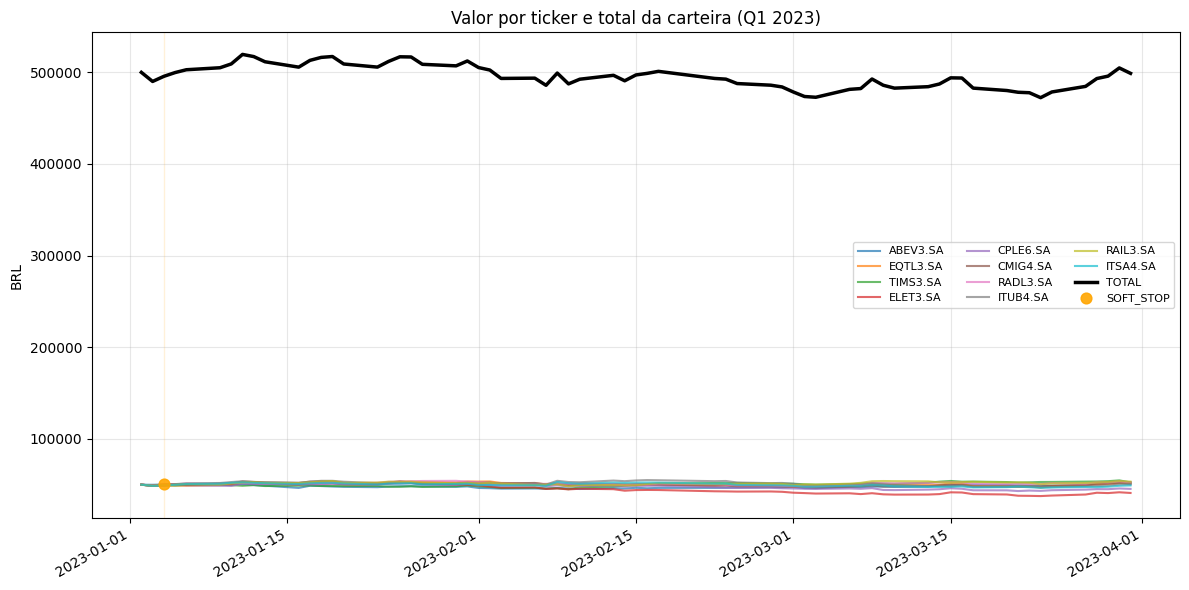

In [28]:
# Celula 10 - Objetivo: plotar valor por ticker + total com marcadores de stop.
plot_index = [d for d in value_by_ticker.index if date(2023, 1, 1) <= d <= date(2023, 3, 31)]

fig, ax = plt.subplots(figsize=(12, 6))
for ticker in tickers:
    ax.plot(plot_index, value_by_ticker.loc[plot_index, ticker], label=ticker, alpha=0.7)

ax.plot(plot_index, total_value.loc[plot_index].values, color="black", linewidth=2.5, label="TOTAL")

soft_label_used = False
hard_label_used = False
for ticker in tickers:
    t_signals = signals[signals["ticker"] == ticker]
    soft_dates = t_signals[t_signals["soft_stop"]]["date"]
    hard_dates = t_signals[t_signals["hard_stop"]]["date"]
    soft_dates = [d for d in soft_dates if d in plot_index]
    hard_dates = [d for d in hard_dates if d in plot_index]
    if soft_dates:
        ax.scatter(
            soft_dates,
            value_by_ticker.loc[soft_dates, ticker],
            marker="o",
            s=60,
            color="orange",
            alpha=0.9,
            label="SOFT_STOP" if not soft_label_used else None,
            zorder=4,
        )
        for d in soft_dates:
            ax.axvline(d, color="orange", alpha=0.15, linewidth=1.0, zorder=1)
        soft_label_used = True
    if hard_dates:
        ax.scatter(
            hard_dates,
            value_by_ticker.loc[hard_dates, ticker],
            marker="x",
            s=80,
            color="red",
            alpha=0.9,
            label="HARD_STOP" if not hard_label_used else None,
            zorder=5,
        )
        for d in hard_dates:
            ax.axvline(d, color="red", alpha=0.2, linewidth=1.2, zorder=1)
        hard_label_used = True

ax.set_title("Valor por ticker e total da carteira (Q1 2023)")
ax.set_ylabel("BRL")
ax.grid(True, alpha=0.3)
ax.legend(ncol=3, fontsize=8)
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig(out_dir / "plot_value.png", dpi=150)
plt.show()


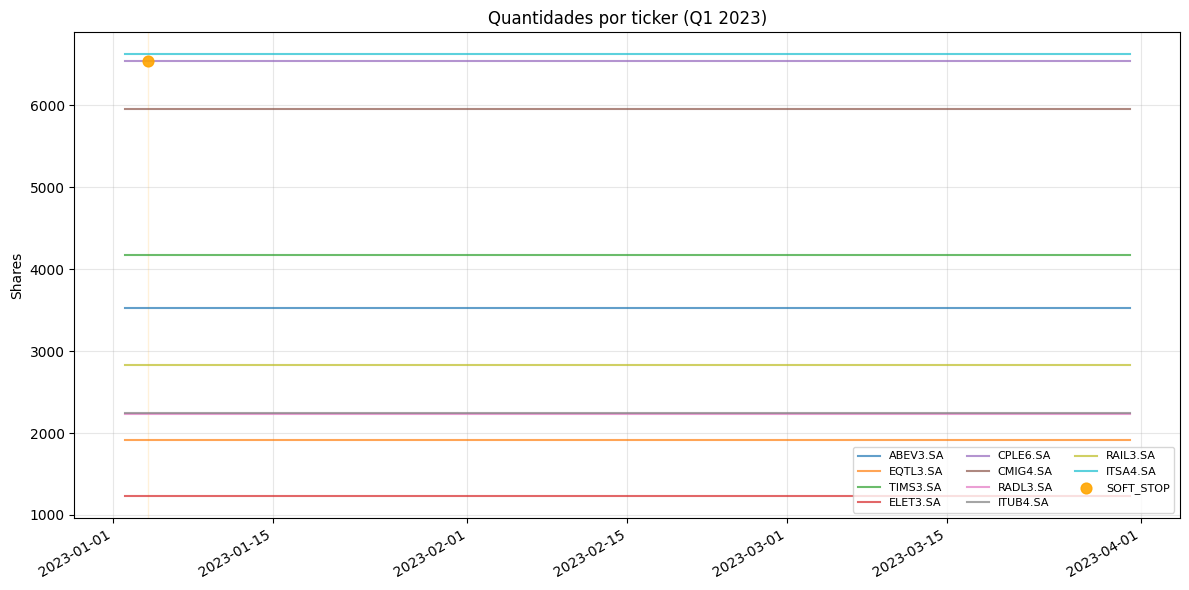

In [29]:
# Celula 11 - Objetivo: plotar quantidades por ticker com marcadores de stop.
qty_ts = pd.DataFrame(index=value_by_ticker.index)
for ticker in tickers:
    qty_ts[ticker] = qty_series[ticker]

plot_index = [d for d in qty_ts.index if date(2023, 1, 1) <= d <= date(2023, 3, 31)]

fig, ax = plt.subplots(figsize=(12, 6))
for ticker in tickers:
    ax.plot(plot_index, qty_ts.loc[plot_index, ticker], label=ticker, alpha=0.7)

soft_label_used = False
hard_label_used = False
for ticker in tickers:
    t_signals = signals[signals["ticker"] == ticker]
    soft_dates = t_signals[t_signals["soft_stop"]]["date"]
    hard_dates = t_signals[t_signals["hard_stop"]]["date"]
    soft_dates = [d for d in soft_dates if d in plot_index]
    hard_dates = [d for d in hard_dates if d in plot_index]
    if soft_dates:
        ax.scatter(
            soft_dates,
            qty_ts.loc[soft_dates, ticker],
            marker="o",
            s=60,
            color="orange",
            alpha=0.9,
            label="SOFT_STOP" if not soft_label_used else None,
            zorder=4,
        )
        for d in soft_dates:
            ax.axvline(d, color="orange", alpha=0.15, linewidth=1.0, zorder=1)
        soft_label_used = True
    if hard_dates:
        ax.scatter(
            hard_dates,
            qty_ts.loc[hard_dates, ticker],
            marker="x",
            s=80,
            color="red",
            alpha=0.9,
            label="HARD_STOP" if not hard_label_used else None,
            zorder=5,
        )
        for d in hard_dates:
            ax.axvline(d, color="red", alpha=0.2, linewidth=1.2, zorder=1)
        hard_label_used = True

ax.set_title("Quantidades por ticker (Q1 2023)")
ax.set_ylabel("Shares")
ax.grid(True, alpha=0.3)
ax.legend(ncol=3, fontsize=8)
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig(out_dir / "plot_qty.png", dpi=150)
plt.show()


In [30]:
# Celula 12 - Objetivo: gerar resumos de sinais (semana, janeiro e Q1).
signals_week = signals[signals["date"].isin(first_week_dates)]
print("Sinais da primeira semana:")
display(signals_week[["date", "ticker", "soft_stop", "hard_stop"]].sort_values(["date", "ticker"]))


def summarize_period(label: str, start: date, end: date) -> None:
    subset = signals[(signals["date"] >= start) & (signals["date"] <= end)]
    counts = subset.groupby("ticker")[["soft_stop", "hard_stop"]].sum().sort_index()
    print(label)
    display(counts)


summarize_period("Janeiro/2023", date(2023, 1, 1), date(2023, 1, 31))
summarize_period("Q1/2023", date(2023, 1, 1), date(2023, 3, 31))

print("\nSinais SOFT_STOP:")
display(
    signals[signals["soft_stop"]][["date", "ticker", "soft_stop", "hard_stop"]].sort_values(
        ["date", "ticker"]
    )
)


Sinais da primeira semana:


,date,ticker,soft_stop,hard_stop
0,2023-01-03,ABEV3.SA,False,False
5,2023-01-03,CMIG4.SA,False,False
4,2023-01-03,CPLE6.SA,False,False
3,2023-01-03,ELET3.SA,False,False
1,2023-01-03,EQTL3.SA,False,False
9,2023-01-03,ITSA4.SA,False,False
7,2023-01-03,ITUB4.SA,False,False
6,2023-01-03,RADL3.SA,False,False
8,2023-01-03,RAIL3.SA,False,False
2,2023-01-03,TIMS3.SA,False,False


Janeiro/2023


,soft_stop,hard_stop
ticker,,
ABEV3.SA,0,0
CMIG4.SA,0,0
CPLE6.SA,1,0
ELET3.SA,0,0
EQTL3.SA,0,0
ITSA4.SA,0,0
ITUB4.SA,0,0
RADL3.SA,0,0
RAIL3.SA,0,0


Q1/2023


,soft_stop,hard_stop
ticker,,
ABEV3.SA,0,0
CMIG4.SA,0,0
CPLE6.SA,1,0
ELET3.SA,0,0
EQTL3.SA,0,0
ITSA4.SA,0,0
ITUB4.SA,0,0
RADL3.SA,0,0
RAIL3.SA,0,0



Sinais SOFT_STOP:


,date,ticker,soft_stop,hard_stop
14,2023-01-04,CPLE6.SA,True,False


In [32]:
# Celula 13 - Objetivo: balanco do fim do Q1 e cenario com venda + recompras.

# 1) Valor da carteira no ultimo dia do Q1 (sem vendas)
q1_dates = [d for d in total_value.index if date(2023, 1, 1) <= d <= date(2023, 3, 31)]
last_q1 = max(q1_dates)
print(f"Ultimo dia do Q1: {last_q1}")
print(f"Valor carteira (sem vendas): {total_value.loc[last_q1]:.2f}")
print(f"Caixa mantido: {cash_left:.2f}")

# 2) Venda de CPLE6 em 04/01/2023 (SOFT_STOP) e caixa no inicio de 05/01
sale_date = date(2023, 1, 4)
if sale_date not in prices_full.index:
    sale_date = min([d for d in prices_full.index if d >= sale_date])
    print(f"Aviso: data venda ajustada para {sale_date}")

cple6_qty = int(qty_series["CPLE6.SA"]) if "CPLE6.SA" in qty_series.index else 0
sell_qty = int(np.floor(cple6_qty * 0.4))
price_sale = float(prices_full.loc[sale_date, "CPLE6.SA"])
proceeds = sell_qty * price_sale
cash_after_sale = cash_left + proceeds
print(f"Venda CPLE6 em {sale_date}: qty={sell_qty}, price={price_sale:.4f}, proceeds={proceeds:.2f}")
print(f"Caixa no inicio de 05/01/2023 (sem D+2): {cash_after_sale:.2f}")

# 3) Compra na proxima segunda-feira (regra alternativa 2 / ruleset_02)
next_monday = min([d for d in trading_dates if d >= date(2023, 1, 9) and d.weekday() == 0])
buy_asof = max([d for d in trading_dates if d < next_monday])

prices_universe_30 = load_prices_for_tickers(universe_30, prices_dir, manifest)
price_slice = prices_universe_30.loc[:buy_asof]
prices_lookback = price_slice.tail(252)

returns = prices_lookback.pct_change()
volatility = returns.std() * np.sqrt(252)
max_drawdown = (1.0 - prices_lookback / prices_lookback.cummax()).max()
ret_total = prices_lookback.iloc[-1] / prices_lookback.iloc[0] - 1.0

ranking = pd.DataFrame(
    {
        "ticker": prices_lookback.columns,
        "max_drawdown": max_drawdown.values,
        "volatility": volatility.values,
        "return": ret_total.values,
    }
).dropna()

ranking = ranking.sort_values(
    ["max_drawdown", "volatility", "return"],
    ascending=[True, True, False],
).reset_index(drop=True)

buy_ticker = ranking.iloc[0]["ticker"]
exec_buy_date = next_monday
if exec_buy_date not in prices_universe_30.index:
    exec_buy_date = min([d for d in prices_universe_30.index if d >= next_monday])
    print(f"Aviso: proxima segunda sem preco, usando exec_date={exec_buy_date}")

buy_price = float(prices_universe_30.loc[exec_buy_date, buy_ticker])
buy_qty = int(np.floor(cash_after_sale / buy_price))

print(f"Compra em {next_monday} (asof {buy_asof})")
print(f"Ticker escolhido: {buy_ticker} | price={buy_price:.4f} | qty={buy_qty}")

cash_after_buy = cash_after_sale - buy_qty * buy_price
print(f"Caixa apos compra: {cash_after_buy:.2f}")

# 4) Verificar se a nova compra dispara algum stop posteriormente
signals_new = signals[(signals["ticker"] == buy_ticker) & (signals["date"] >= next_monday)]
print("\nSinais para o novo ticker apos compra:")
display(signals_new[["date", "ticker", "soft_stop", "hard_stop"]].head(20))


Ultimo dia do Q1: 2023-03-31
Valor carteira (sem vendas): 498915.11
Caixa mantido: 111.48
Venda CPLE6 em 2023-01-04: qty=2618, price=7.7078, proceeds=20179.11
Caixa no inicio de 05/01/2023 (sem D+2): 20290.60
Compra em 2023-01-09 (asof 2023-01-06)
Ticker escolhido: ABEV3.SA | price=14.4000 | qty=1409
Caixa apos compra: 1.00

Sinais para o novo ticker apos compra:


,date,ticker,soft_stop,hard_stop
40,2023-01-09,ABEV3.SA,False,False
50,2023-01-10,ABEV3.SA,False,False
60,2023-01-11,ABEV3.SA,False,False
70,2023-01-12,ABEV3.SA,False,False
80,2023-01-13,ABEV3.SA,False,False
90,2023-01-16,ABEV3.SA,False,False
100,2023-01-17,ABEV3.SA,False,False
110,2023-01-18,ABEV3.SA,False,False
120,2023-01-19,ABEV3.SA,False,False
130,2023-01-20,ABEV3.SA,False,False


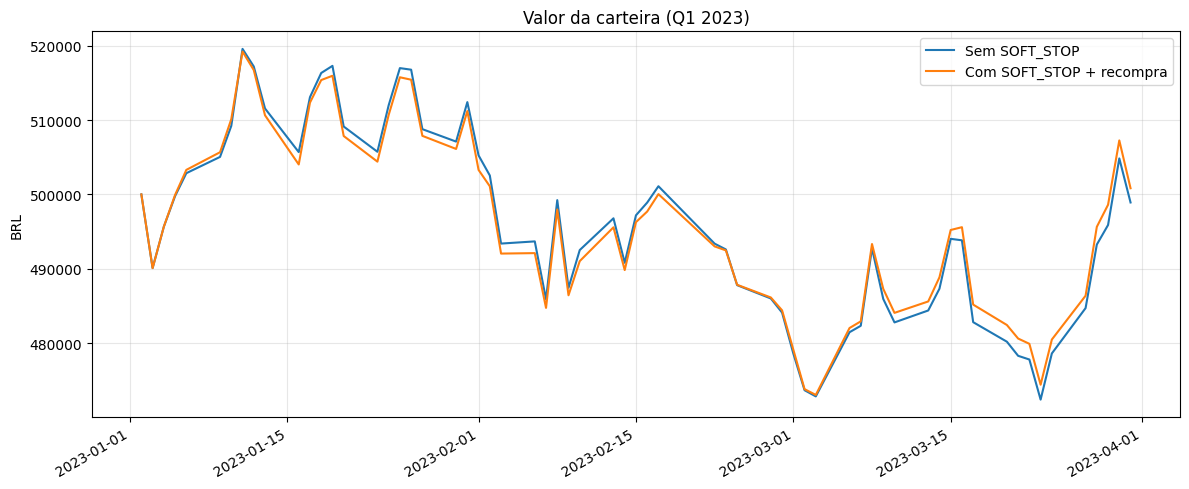

Valor final Q1 sem venda: 498915.11
Valor final Q1 com SOFT_STOP: 500831.78


In [33]:
# Celula 14 - Objetivo: comparar valor carteira com/sem SOFT_STOP.

plot_index = [d for d in total_value.index if date(2023, 1, 1) <= d <= date(2023, 3, 31)]
base_series = total_value.loc[plot_index]

# Reconstituir cenario com venda CPLE6 em 04/01 e compra na proxima segunda
sale_date_exec = date(2023, 1, 4)
if sale_date_exec not in prices_full.index:
    sale_date_exec = min([d for d in prices_full.index if d >= sale_date_exec])

holdings_before = qty_series.to_dict()
holdings_after_sale = holdings_before.copy()

sell_qty = int(np.floor(holdings_after_sale.get("CPLE6.SA", 0) * 0.4))
price_sale = float(prices_full.loc[sale_date_exec, "CPLE6.SA"])
cash_after_sale = cash_left + sell_qty * price_sale
holdings_after_sale["CPLE6.SA"] = holdings_after_sale.get("CPLE6.SA", 0) - sell_qty

# Compra na proxima segunda-feira (mesma logica do ruleset_02)
next_monday = min([d for d in trading_dates if d >= date(2023, 1, 9) and d.weekday() == 0])
exec_buy_date = next_monday
if exec_buy_date not in prices_universe_30.index:
    exec_buy_date = min([d for d in prices_universe_30.index if d >= next_monday])

buy_price = float(prices_universe_30.loc[exec_buy_date, buy_ticker])
buy_qty = int(np.floor(cash_after_sale / buy_price))
cash_after_buy = cash_after_sale - buy_qty * buy_price

holdings_after_buy = holdings_after_sale.copy()
holdings_after_buy[buy_ticker] = holdings_after_buy.get(buy_ticker, 0) + buy_qty


def _get_price(d: date, ticker: str) -> float:
    if ticker in prices_universe_30.columns and d in prices_universe_30.index:
        return float(prices_universe_30.at[d, ticker])
    return float(prices_full.at[d, ticker])


scenario_values = []
for d in plot_index:
    if d <= sale_date_exec:
        holdings = holdings_before
        cash = cash_left
    elif d < exec_buy_date:
        holdings = holdings_after_sale
        cash = cash_after_sale
    else:
        holdings = holdings_after_buy
        cash = cash_after_buy

    total = cash
    for t, q in holdings.items():
        if q <= 0:
            continue
        total += q * _get_price(d, t)
    scenario_values.append(total)

scenario_series = pd.Series(scenario_values, index=plot_index)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(base_series.index, base_series.values, label="Sem SOFT_STOP")
ax.plot(scenario_series.index, scenario_series.values, label="Com SOFT_STOP + recompra")
ax.set_title("Valor da carteira (Q1 2023)")
ax.set_ylabel("BRL")
ax.grid(True, alpha=0.3)
ax.legend()
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

print(f"Valor final Q1 sem venda: {base_series.iloc[-1]:.2f}")
print(f"Valor final Q1 com SOFT_STOP: {scenario_series.iloc[-1]:.2f}")


/tmp/ipykernel_26704/1797298582.py:13: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices_universe_30.pct_change()


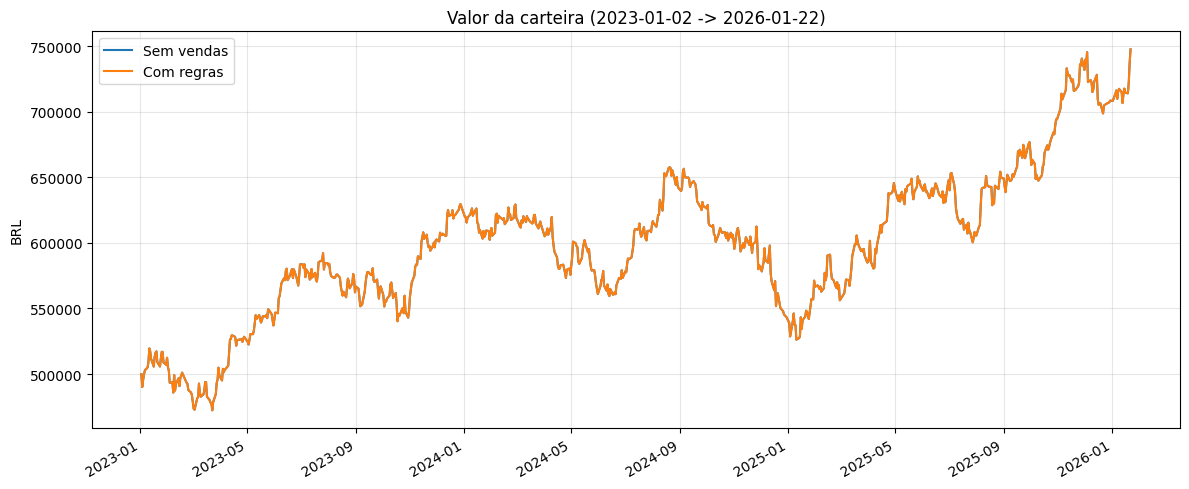

Valor final sem vendas: 747476.48
Valor final com regras: 747476.48


In [47]:
# Celula 15 - Objetivo: simular 2023 com regras e comparar com baseline.

# Preparar universo e datas
prices_universe_30 = load_prices_for_tickers(universe_30, prices_dir, manifest)
prices_universe_30_ffill = prices_universe_30.sort_index().ffill()
prices_full_ffill = prices_full.sort_index().ffill()
last_date_data = max([d for d in prices_universe_30_ffill.index if d <= end_range])
sim_dates = [d for d in prices_universe_30_ffill.index if d >= d0 and d <= last_date_data]

# Metricas rolling (as-of D-1) para todo universo
drawdown_20 = 1.0 - prices_universe_30 / prices_universe_30.rolling(20, min_periods=20).max()
drawdown_60 = 1.0 - prices_universe_30 / prices_universe_30.rolling(60, min_periods=60).max()
returns = prices_universe_30.pct_change()
vol_60 = returns.rolling(60, min_periods=60).std() * np.sqrt(252)
vol_252 = returns.rolling(252, min_periods=252).std() * np.sqrt(252)
vol_ratio = vol_60 / vol_252

_dd20 = drawdown_20.shift(1)
_dd60 = drawdown_60.shift(1)
_vol_ratio = vol_ratio.shift(1)


def get_ranked_universe(asof_date: date, universe: list[str]) -> list[str]:
    price_slice = prices_universe_30.loc[:asof_date, universe].tail(252)
    rets = price_slice.pct_change(fill_method=None)
    vol = rets.std() * np.sqrt(252)
    dd = (1.0 - price_slice / price_slice.cummax()).max()
    ret_total = price_slice.iloc[-1] / price_slice.iloc[0] - 1.0
    ranking = pd.DataFrame(
        {"ticker": price_slice.columns, "max_drawdown": dd.values, "volatility": vol.values, "return": ret_total.values}
    ).dropna()
    ranking = ranking.sort_values(["max_drawdown", "volatility", "return"], ascending=[True, True, False])
    return ranking["ticker"].tolist()


def price_on(d: date, ticker: str) -> float:
    if ticker in prices_universe_30_ffill.columns:
        return float(prices_universe_30_ffill.at[d, ticker])
    return float(prices_full_ffill.at[d, ticker])


# Baseline (sem venda) - valor da carteira ao longo do periodo
baseline_values = []
for d in sim_dates:
    total = cash_left
    for t, q in qty_series.items():
        total += q * float(prices_full_ffill.at[d, t])
    baseline_values.append(total)
baseline_2023 = pd.Series(baseline_values, index=sim_dates)

# Cenario com regras
positions = qty_series.to_dict()
cash = float(cash_left)

fee_percent = float(spec.get("dry_run_execution", {}).get("fees", {}).get("fee_percent_per_order", 0.0))
fee_fixed = float(spec.get("dry_run_execution", {}).get("fees", {}).get("fee_fixed_brl_per_order", 0.0))
min_notional = float(ruleset.get("actions", {}).get("reduce", {}).get("min_notional_brl_to_trade", 1000.0))


def snapshot_positions(pos: dict) -> str:
    items = [f"{k}:{v}" for k, v in sorted(pos.items()) if v > 0]
    return ";".join(items)


events = []
scenario_values = []

for idx, current_date in enumerate(sim_dates):
    if idx == 0:
        scenario_values.append(cash + sum(positions[t] * price_on(current_date, t) for t in positions))
        continue

    asof_date = sim_dates[idx - 1]

    # 1) Aplicar stops (HARD > SOFT)
    for ticker in list(positions.keys()):
        if positions[ticker] <= 0:
            continue
        dd20 = _dd20.at[asof_date, ticker]
        dd60 = _dd60.at[asof_date, ticker]
        vr = _vol_ratio.at[asof_date, ticker]

        hard = (vr >= 1.8) and (dd60 >= 0.12)
        soft = (vr >= 1.6) and (dd20 >= 0.06)

        if hard:
            qty_sell = positions[ticker]
            price = price_on(current_date, ticker)
            notional = qty_sell * price
            fee_total = notional * fee_percent + fee_fixed
            if notional >= min_notional:
                cash += notional - fee_total
                positions[ticker] = 0
                events.append(
                    {
                        "date": current_date,
                        "action": "SELL",
                        "ticker": ticker,
                        "reason": "HARD_STOP",
                        "qty": qty_sell,
                        "price": price,
                        "fee_total": fee_total,
                        "cash_after": cash,
                        "positions": snapshot_positions(positions),
                    }
                )
            else:
                events.append(
                    {
                        "date": current_date,
                        "action": "SKIP_SELL",
                        "ticker": ticker,
                        "reason": "HARD_STOP_MIN_NOTIONAL",
                        "qty": qty_sell,
                        "price": price,
                        "fee_total": fee_total,
                        "cash_after": cash,
                        "positions": snapshot_positions(positions),
                    }
                )
        elif soft:
            qty_sell = int(np.floor(positions[ticker] * 0.4))
            if qty_sell > 0:
                price = price_on(current_date, ticker)
                notional = qty_sell * price
                fee_total = notional * fee_percent + fee_fixed
                if notional >= min_notional:
                    cash += notional - fee_total
                    positions[ticker] -= qty_sell
                    events.append(
                        {
                            "date": current_date,
                            "action": "SELL",
                            "ticker": ticker,
                            "reason": "SOFT_STOP",
                            "qty": qty_sell,
                            "price": price,
                            "fee_total": fee_total,
                            "cash_after": cash,
                            "positions": snapshot_positions(positions),
                        }
                    )
                else:
                    events.append(
                        {
                            "date": current_date,
                            "action": "SKIP_SELL",
                            "ticker": ticker,
                            "reason": "SOFT_STOP_MIN_NOTIONAL",
                            "qty": qty_sell,
                            "price": price,
                            "fee_total": fee_total,
                            "cash_after": cash,
                            "positions": snapshot_positions(positions),
                        }
                    )

    positions = {t: q for t, q in positions.items() if q > 0}

    # 2) Compra semanal (segunda-feira)
    if current_date.weekday() == 0 and cash > 0:
        ranked = get_ranked_universe(asof_date, universe_30)
        missing = [t for t in ranked if t not in positions]

        # alvo de equalizacao por valor
        total_val = cash + sum(positions[t] * price_on(current_date, t) for t in positions)
        target_val = total_val / 10.0

        desired = {}
        # novos
        for t in missing:
            desired[t] = target_val
        # existentes (top-up)
        for t in positions:
            current_val = positions[t] * price_on(current_date, t)
            desired[t] = max(target_val - current_val, 0.0)

        total_desired = sum(desired.values())
        if total_desired > 0:
            for t, want in desired.items():
                if cash <= 0:
                    break
                if want <= 0:
                    continue
                alloc = cash * (want / total_desired)
                price = price_on(current_date, t)
                qty_buy = int(np.floor(alloc / price))
                if qty_buy <= 0:
                    continue
                notional = qty_buy * price
                fee_total = notional * fee_percent + fee_fixed
                total_cost = notional + fee_total
                if notional < min_notional or total_cost > cash:
                    continue
                cash -= total_cost
                positions[t] = positions.get(t, 0) + qty_buy
                events.append(
                    {
                        "date": current_date,
                        "action": "BUY",
                        "ticker": t,
                        "reason": "WEEKLY_BUY",
                        "qty": qty_buy,
                        "price": price,
                        "fee_total": fee_total,
                        "cash_after": cash,
                        "positions": snapshot_positions(positions),
                    }
                )

    # 3) Valor da carteira
    total_now = cash + sum(positions[t] * price_on(current_date, t) for t in positions)
    scenario_values.append(total_now)

scenario_2023 = pd.Series(scenario_values, index=sim_dates)

# Adicionar valor da carteira em cada evento
if events:
    event_df = pd.DataFrame(events)
    event_values = []
    for _, row in event_df.iterrows():
        d = row["date"]
        total_now = scenario_2023.loc[d]
        event_values.append(total_now)
    event_df["portfolio_value"] = event_values
    display(event_df)

# Grafico comparativo
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(baseline_2023.index, baseline_2023.values, label="Sem vendas")
ax.plot(scenario_2023.index, scenario_2023.values, label="Com regras")
ax.set_title(f"Valor da carteira ({d0} -> {last_date_data})")
ax.set_ylabel("BRL")
ax.grid(True, alpha=0.3)
ax.legend()
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

print(f"Valor final sem vendas: {baseline_2023.iloc[-1]:.2f}")
print(f"Valor final com regras: {scenario_2023.iloc[-1]:.2f}")


In [46]:
# Celula 16 - Objetivo: auditoria de sinais e stops (focus CPLE6 e 04/01/2023).

# 1) Quantidade total de SOFT/HARD no periodo
soft_count = int(signals["soft_stop"].sum())
hard_count = int(signals["hard_stop"].sum())
print(f"Total SOFT_STOP no signals: {soft_count}")
print(f"Total HARD_STOP no signals: {hard_count}")

# 2) Mostrar primeiros sinais (se houver)
if soft_count > 0:
    display(signals[signals["soft_stop"]][["date", "ticker", "drawdown_20d", "drawdown_60d", "vol_60d_over_vol_252d"]].head(10))
if hard_count > 0:
    display(signals[signals["hard_stop"]][["date", "ticker", "drawdown_20d", "drawdown_60d", "vol_60d_over_vol_252d"]].head(10))

# 3) Auditoria especifica CPLE6 em 2023-01-04 (asof 2023-01-03)
check_date = date(2023, 1, 4)
asof_date = date(2023, 1, 3)
row = signals[(signals["date"] == check_date) & (signals["ticker"] == "CPLE6.SA")]
print("\nSinal CPLE6 em 2023-01-04 (asof 2023-01-03):")
if not row.empty:
    display(row[["date", "ticker", "drawdown_20d", "drawdown_60d", "vol_60d_over_vol_252d", "soft_stop", "hard_stop"]])
else:
    print("Nao encontrado no signals.")

# 4) Recalculo manual do as-of para CPLE6 usando prices_full
series = prices_full_ffill.loc[:asof_date, "CPLE6.SA"].dropna()

if len(series) >= 20:
    dd20 = 1.0 - series.iloc[-1] / series.iloc[-20:].max()
else:
    dd20 = np.nan
if len(series) >= 60:
    dd60 = 1.0 - series.iloc[-1] / series.iloc[-60:].max()
else:
    dd60 = np.nan
if len(series) >= 252:
    rets = series.pct_change().dropna()
    if len(rets) >= 60:
        vol60 = rets.iloc[-60:].std() * np.sqrt(252)
        vol252 = rets.iloc[-252:].std() * np.sqrt(252)
        vol_ratio = vol60 / vol252 if vol252 and not np.isnan(vol252) else np.nan
    else:
        vol_ratio = np.nan
else:
    vol_ratio = np.nan

soft_manual = (vol_ratio >= 1.6) and (dd20 >= 0.06)
hard_manual = (vol_ratio >= 1.8) and (dd60 >= 0.12)

print(f"Manual CPLE6 asof 2023-01-03 -> dd20={dd20}, dd60={dd60}, vol_ratio={vol_ratio}")
print(f"Manual soft={soft_manual} hard={hard_manual}")


Total SOFT_STOP no signals: 1
Total HARD_STOP no signals: 0


,date,ticker,drawdown_20d,drawdown_60d,vol_60d_over_vol_252d
14,2023-01-04,CPLE6.SA,0.066003,0.141876,1.630726



Sinal CPLE6 em 2023-01-04 (asof 2023-01-03):


,date,ticker,drawdown_20d,drawdown_60d,vol_60d_over_vol_252d,soft_stop,hard_stop
14,2023-01-04,CPLE6.SA,0.066003,0.141876,1.630726,True,False


Manual CPLE6 asof 2023-01-03 -> dd20=0.06600252254148731, dd60=0.14187637388424768, vol_ratio=1.6307263842339301
Manual soft=True hard=False


/tmp/ipykernel_26704/1309655325.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ibov = yf.download("^BVSP", start=start_dt, end=end_dt, progress=False)


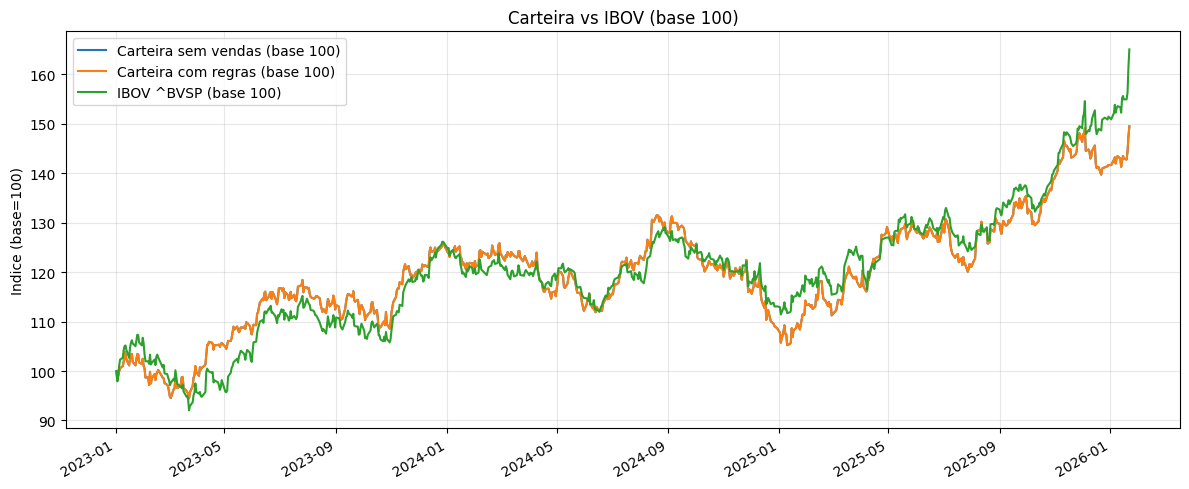

In [50]:
# Celula 17 - Objetivo: baixar IBOV (B3) via yfinance e plotar junto.

import yfinance as yf

start_dt = pd.Timestamp(d0)
end_dt = pd.Timestamp(last_date_data) + pd.Timedelta(days=1)

ibov = yf.download("^BVSP", start=start_dt, end=end_dt, progress=False)
if ibov.empty:
    raise ValueError("Nao foi possivel baixar ^BVSP via yfinance.")

if isinstance(ibov.columns, pd.MultiIndex):
    if "Close" in ibov.columns.get_level_values(0):
        ibov_series = ibov.xs("Close", level=0, axis=1).iloc[:, 0]
    elif "Close" in ibov.columns.get_level_values(1):
        ibov_series = ibov.xs("Close", level=1, axis=1).iloc[:, 0]
    else:
        raise KeyError("Close nao encontrado em MultiIndex")
else:
    if "Close" in ibov.columns:
        ibov_series = ibov["Close"]
    else:
        raise KeyError("Close nao encontrado no yfinance")

ibov_series = ibov_series.dropna().rename("IBOV")

# alinhar no mesmo indice da simulacao
ibov_aligned = ibov_series.reindex(sim_dates).ffill()
ibov_norm = ibov_aligned / ibov_aligned.iloc[0] * 100.0

# normalizar carteira em base 100 para comparar
base_norm = baseline_2023 / baseline_2023.iloc[0] * 100.0
rules_norm = scenario_2023 / scenario_2023.iloc[0] * 100.0

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(base_norm.index, base_norm.values, label="Carteira sem vendas (base 100)")
ax.plot(rules_norm.index, rules_norm.values, label="Carteira com regras (base 100)")
ax.plot(ibov_norm.index, ibov_norm.values, label="IBOV ^BVSP (base 100)")
ax.set_title("Carteira vs IBOV (base 100)")
ax.set_ylabel("Indice (base=100)")
ax.grid(True, alpha=0.3)
ax.legend()
fig.autofmt_xdate()
fig.tight_layout()
plt.show()


In [ ]:
# Celula 18 - Objetivo: setup v2 (paths, output e universo).

out_dir_v2 = lab_root / "outputs/prop2_v2_full_period_audit"
out_dir_v2.mkdir(parents=True, exist_ok=True)

end_target = date(2026, 1, 22)

supervised_df = pd.read_parquet(universe_supervised_path)
supervised_tickers = sorted(supervised_df["ticker"].dropna().unique().tolist())

candidate_path = repo_root / data_contracts.get("universe_candidates_file", "")
candidate_tickers = []
if candidate_path.exists():
    cand_df = pd.read_parquet(candidate_path)
    if "ticker" in cand_df.columns:
        candidate_tickers = sorted(cand_df["ticker"].dropna().unique().tolist())
    elif "symbol" in cand_df.columns:
        candidate_tickers = sorted(cand_df["symbol"].dropna().unique().tolist())

if not candidate_tickers:
    candidate_tickers = supervised_tickers.copy()

all_universe = sorted(set(supervised_tickers) | set(candidate_tickers))

prices_all_universe = load_prices_for_tickers(all_universe, prices_dir, manifest)
prices_all_universe = prices_all_universe.sort_index().ffill()

# IBOV local (_BVSP) com fallback para yfinance
ibov_series = None
try:
    if ibov_ticker:
        ibov_series = load_price_series(ibov_ticker, prices_dir, manifest)
except Exception:
    ibov_series = None

if ibov_series is None:
    import yfinance as yf

    ibov_df = yf.download("^BVSP", start=pd.Timestamp(d0), end=pd.Timestamp(end_target) + pd.Timedelta(days=1), progress=False)
    if ibov_df.empty:
        raise ValueError("Nao foi possivel baixar ^BVSP via yfinance.")
    if isinstance(ibov_df.columns, pd.MultiIndex):
        ibov_series = ibov_df.xs("Close", level=0, axis=1).iloc[:, 0]
    else:
        ibov_series = ibov_df["Close"]

ibov_series = ibov_series.dropna()
ibov_series.index = pd.to_datetime(ibov_series.index).date

# Calendario e datas
last_date_data = max([d for d in prices_all_universe.index if d <= end_target])
sim_dates = [d for d in prices_all_universe.index if d >= d0 and d <= last_date_data]

print(f"Periodo v2: {sim_dates[0]} -> {sim_dates[-1]}")
print(f"Universe supervised: {len(supervised_tickers)} | candidates: {len(candidate_tickers)} | total: {len(all_universe)}")


In [ ]:
# Celula 19 - Objetivo: metricas as-of D-1 (ticker e IBOV).

# Ticker metrics (v2)
dd20 = 1.0 - prices_all_universe / prices_all_universe.rolling(20, min_periods=20).max()
dd60 = 1.0 - prices_all_universe / prices_all_universe.rolling(60, min_periods=60).max()
rets = prices_all_universe.pct_change(fill_method=None)
vol60 = rets.rolling(60, min_periods=60).std() * np.sqrt(252)
vol252 = rets.rolling(252, min_periods=252).std() * np.sqrt(252)
vol_ratio = vol60 / vol252

_dd20 = dd20.shift(1)
_dd60 = dd60.shift(1)
_vol_ratio = vol_ratio.shift(1)

# IBOV metrics (v2)
ibov = ibov_series.reindex(sim_dates).ffill()
ibov_dd20 = 1.0 - ibov / ibov.rolling(20, min_periods=20).max()
ibov_dd60 = 1.0 - ibov / ibov.rolling(60, min_periods=60).max()

_ibov_dd20 = ibov_dd20.shift(1)
_ibov_dd60 = ibov_dd60.shift(1)


In [ ]:
# Celula 20 - Objetivo: simular v2 com auditoria completa.

fee_percent = float(spec.get("dry_run_execution", {}).get("fees", {}).get("fee_percent_per_order", 0.0))
fee_fixed = float(spec.get("dry_run_execution", {}).get("fees", {}).get("fee_fixed_brl_per_order", 0.0))
min_notional_buy = 1000.0
min_notional_sell = 0.0
sell_settle_days = int(spec.get("dry_run_execution", {}).get("sell_settlement_days", 2))
quarantine_sessions = int(spec.get("quarantine", {}).get("sessions_after_zero", 10))


positions = qty_series.to_dict()
cash = float(cash_left)
quarantine = {}
pending_cash = []


def snapshot_positions(pos: dict) -> str:
    items = [f"{k}:{v}" for k, v in sorted(pos.items()) if v > 0]
    return ";".join(items)


def settle_cash(current_date: date) -> float:
    nonlocal_pending = []
    added = 0.0
    for item in pending_cash:
        if item["settle_date"] <= current_date:
            added += float(item["amount"])
        else:
            nonlocal_pending.append(item)
    pending_cash.clear()
    pending_cash.extend(nonlocal_pending)
    return added


def price_on(d: date, ticker: str) -> float | None:
    if ticker in prices_all_universe.columns and d in prices_all_universe.index:
        val = prices_all_universe.at[d, ticker]
        return float(val) if pd.notna(val) else None
    return None


def ibov_brake(asof_date: date) -> tuple[str, float]:
    dd20_val = _ibov_dd20.at[asof_date] if asof_date in _ibov_dd20.index else np.nan
    dd60_val = _ibov_dd60.at[asof_date] if asof_date in _ibov_dd60.index else np.nan
    if pd.notna(dd60_val) and dd60_val >= 0.08:
        return "HARD", 0.30
    if pd.notna(dd20_val) and dd20_val >= 0.04:
        return "SOFT", 0.15
    return "NONE", 0.0


def ticker_signal(asof_date: date, ticker: str) -> tuple[bool, bool]:
    dd20_val = _dd20.at[asof_date, ticker] if ticker in _dd20.columns and asof_date in _dd20.index else np.nan
    dd60_val = _dd60.at[asof_date, ticker] if ticker in _dd60.columns and asof_date in _dd60.index else np.nan
    vr_val = _vol_ratio.at[asof_date, ticker] if ticker in _vol_ratio.columns and asof_date in _vol_ratio.index else np.nan

    soft = (pd.notna(dd20_val) and dd20_val >= 0.04) or (pd.notna(vr_val) and vr_val >= 1.40)
    hard = (pd.notna(dd60_val) and dd60_val >= 0.10) and (pd.notna(vr_val) and vr_val >= 1.60)
    return soft, hard


def get_ranked_universe(asof_date: date, universe: list[str]) -> list[str]:
    price_slice = prices_all_universe.loc[:asof_date, universe].tail(252)
    rets = price_slice.pct_change(fill_method=None)
    vol = rets.std() * np.sqrt(252)
    dd = (1.0 - price_slice / price_slice.cummax()).max()
    ret_total = price_slice.iloc[-1] / price_slice.iloc[0] - 1.0
    ranking = pd.DataFrame(
        {"ticker": price_slice.columns, "max_drawdown": dd.values, "volatility": vol.values, "return": ret_total.values}
    ).dropna()
    ranking = ranking.sort_values(["max_drawdown", "volatility", "return"], ascending=[True, True, False])
    return ranking["ticker"].tolist()


def get_ranked_default(asof_date: date) -> list[str]:
    ranked = get_ranked_universe(asof_date, supervised_tickers)
    return ranked


def get_ranked_candidate(asof_date: date) -> list[str]:
    price_slice = prices_all_universe.loc[:asof_date, candidate_tickers].tail(60)
    rets = price_slice.pct_change(fill_method=None)
    dd = (1.0 - price_slice / price_slice.cummax()).max()
    ret_total = price_slice.iloc[-1] / price_slice.iloc[0] - 1.0
    ranking = pd.DataFrame(
        {"ticker": price_slice.columns, "dd20": dd.values, "ret": ret_total.values}
    ).dropna()
    ranking = ranking[(ranking["dd20"] < 0.06)]
    ranking = ranking.sort_values(["ret", "ticker"], ascending=[False, True])
    return ranking["ticker"].tolist()


# Logs

day_rows = []
ticker_rows = []
event_rows = []

for idx, current_date in enumerate(sim_dates):
    weekday = current_date.weekday()

    # settlements
    cash += settle_cash(current_date)
    cash_bod = cash

    # decrement quarantine
    for t in list(quarantine.keys()):
        quarantine[t] -= 1
        if quarantine[t] <= 0:
            quarantine.pop(t, None)

    asof_date = sim_dates[idx - 1] if idx > 0 else current_date

    ibov_sig, ibov_frac = ibov_brake(asof_date)
    ibov_action_taken = "NONE"
    reason_if_not_acted = ""

    acted_today = set()

    # IBOV brake signal
    if ibov_sig != "NONE":
        event_rows.append(
            {
                "timestamp_or_date": current_date,
                "event_type": "SIGNAL",
                "scope": "IBOV",
                "ticker": "_BVSP",
                "signal_type": ibov_sig,
                "action": "REDUCE_UNIFORM",
                "qty": None,
                "price": None,
                "notional": None,
                "cash_before": cash_bod,
                "cash_after": None,
                "reason_code": None,
                "reason_detail": None,
            }
        )

        if positions:
            for t, q in list(positions.items()):
                if t in acted_today:
                    continue
                price = price_on(current_date, t)
                if price is None:
                    event_rows.append(
                        {
                            "timestamp_or_date": current_date,
                            "event_type": "SKIP",
                            "scope": "TICKER",
                            "ticker": t,
                            "signal_type": ibov_sig,
                            "action": "REDUCE_UNIFORM",
                            "qty": 0,
                            "price": None,
                            "notional": None,
                            "cash_before": cash,
                            "cash_after": cash,
                            "reason_code": "NO_PRICE",
                            "reason_detail": "IBOV_BRAKE",
                        }
                    )
                    continue
                qty_sell = int(np.floor(q * ibov_frac))
                if qty_sell <= 0:
                    event_rows.append(
                        {
                            "timestamp_or_date": current_date,
                            "event_type": "SKIP",
                            "scope": "TICKER",
                            "ticker": t,
                            "signal_type": ibov_sig,
                            "action": "REDUCE_UNIFORM",
                            "qty": qty_sell,
                            "price": price,
                            "notional": 0.0,
                            "cash_before": cash,
                            "cash_after": cash,
                            "reason_code": "NO_POSITION",
                            "reason_detail": "IBOV_BRAKE",
                        }
                    )
                    continue
                notional = qty_sell * price
                fee_total = notional * fee_percent + fee_fixed
                cashflow = notional - fee_total
                pending_cash.append(
                    {
                        "settle_date": sim_dates[min(idx + sell_settle_days, len(sim_dates) - 1)],
                        "amount": cashflow,
                    }
                )
                positions[t] -= qty_sell
                ibov_action_taken = "REDUCE_UNIFORM"
                acted_today.add(t)
                event_rows.append(
                    {
                        "timestamp_or_date": current_date,
                        "event_type": "ORDER",
                        "scope": "TICKER",
                        "ticker": t,
                        "signal_type": ibov_sig,
                        "action": "SELL",
                        "qty": qty_sell,
                        "price": price,
                        "notional": notional,
                        "cash_before": cash,
                        "cash_after": cash,
                        "reason_code": None,
                        "reason_detail": "IBOV_BRAKE",
                    }
                )
        else:
            reason_if_not_acted = "NO_POSITION"

    # Ticker stops
    for t, q in list(positions.items()):
        if t in acted_today:
            continue
        soft, hard = ticker_signal(asof_date, t)
        if not soft and not hard:
            continue

        event_rows.append(
            {
                "timestamp_or_date": current_date,
                "event_type": "SIGNAL",
                "scope": "TICKER",
                "ticker": t,
                "signal_type": "HARD" if hard else "SOFT",
                "action": "ZERO" if hard else "REDUCE",
                "qty": None,
                "price": None,
                "notional": None,
                "cash_before": cash_bod,
                "cash_after": None,
                "reason_code": None,
                "reason_detail": None,
            }
        )

        price = price_on(current_date, t)
        if price is None:
            event_rows.append(
                {
                    "timestamp_or_date": current_date,
                    "event_type": "SKIP",
                    "scope": "TICKER",
                    "ticker": t,
                    "signal_type": "HARD" if hard else "SOFT",
                    "action": "ZERO" if hard else "REDUCE",
                    "qty": 0,
                    "price": None,
                    "notional": None,
                    "cash_before": cash,
                    "cash_after": cash,
                    "reason_code": "NO_PRICE",
                    "reason_detail": None,
                }
            )
            continue

        if hard:
            qty_sell = q
        else:
            qty_sell = int(np.floor(q * 0.25))

        if qty_sell <= 0:
            event_rows.append(
                {
                    "timestamp_or_date": current_date,
                    "event_type": "SKIP",
                    "scope": "TICKER",
                    "ticker": t,
                    "signal_type": "HARD" if hard else "SOFT",
                    "action": "ZERO" if hard else "REDUCE",
                    "qty": qty_sell,
                    "price": price,
                    "notional": 0.0,
                    "cash_before": cash,
                    "cash_after": cash,
                    "reason_code": "NO_POSITION",
                    "reason_detail": None,
                }
            )
            continue

        notional = qty_sell * price
        fee_total = notional * fee_percent + fee_fixed
        cashflow = notional - fee_total
        pending_cash.append(
            {
                "settle_date": sim_dates[min(idx + sell_settle_days, len(sim_dates) - 1)],
                "amount": cashflow,
            }
        )
        positions[t] -= qty_sell
        if hard:
            quarantine[t] = quarantine_sessions
        acted_today.add(t)
        event_rows.append(
            {
                "timestamp_or_date": current_date,
                "event_type": "ORDER",
                "scope": "TICKER",
                "ticker": t,
                "signal_type": "HARD" if hard else "SOFT",
                "action": "SELL",
                "qty": qty_sell,
                "price": price,
                "notional": notional,
                "cash_before": cash,
                "cash_after": cash,
                "reason_code": None,
                "reason_detail": None,
            }
        )

    positions = {t: q for t, q in positions.items() if q > 0}

    # Weekly buy (segunda)
    if weekday == 0 and cash_bod >= min_notional_buy and cash > 0:
        ranked = get_ranked_default(asof_date)
        ranked = [t for t in ranked if t not in quarantine]
        ranked = [t for t in ranked if price_on(current_date, t) is not None]

        if not ranked:
            event_rows.append(
                {
                    "timestamp_or_date": current_date,
                    "event_type": "SKIP",
                    "scope": "TICKER",
                    "ticker": None,
                    "signal_type": None,
                    "action": "BUY",
                    "qty": 0,
                    "price": None,
                    "notional": None,
                    "cash_before": cash,
                    "cash_after": cash,
                    "reason_code": "NO_PRICE",
                    "reason_detail": None,
                }
            )
        else:
            selected = ranked[:10]
            budget_per = cash / len(selected)
            for t in selected:
                price = price_on(current_date, t)
                qty_buy = int(np.floor(budget_per / price))
                if qty_buy <= 0:
                    event_rows.append(
                        {
                            "timestamp_or_date": current_date,
                            "event_type": "SKIP",
                            "scope": "TICKER",
                            "ticker": t,
                            "signal_type": None,
                            "action": "BUY",
                            "qty": 0,
                            "price": price,
                            "notional": 0.0,
                            "cash_before": cash,
                            "cash_after": cash,
                            "reason_code": "MIN_NOTIONAL_BUY",
                            "reason_detail": None,
                        }
                    )
                    continue
                notional = qty_buy * price
                if notional < min_notional_buy:
                    event_rows.append(
                        {
                            "timestamp_or_date": current_date,
                            "event_type": "SKIP",
                            "scope": "TICKER",
                            "ticker": t,
                            "signal_type": None,
                            "action": "BUY",
                            "qty": qty_buy,
                            "price": price,
                            "notional": notional,
                            "cash_before": cash,
                            "cash_after": cash,
                            "reason_code": "MIN_NOTIONAL_BUY",
                            "reason_detail": None,
                        }
                    )
                    continue
                fee_total = notional * fee_percent + fee_fixed
                total_cost = notional + fee_total
                if total_cost > cash:
                    event_rows.append(
                        {
                            "timestamp_or_date": current_date,
                            "event_type": "SKIP",
                            "scope": "TICKER",
                            "ticker": t,
                            "signal_type": None,
                            "action": "BUY",
                            "qty": qty_buy,
                            "price": price,
                            "notional": notional,
                            "cash_before": cash,
                            "cash_after": cash,
                            "reason_code": "NO_CASH",
                            "reason_detail": None,
                        }
                    )
                    continue
                cash -= total_cost
                positions[t] = positions.get(t, 0) + qty_buy
                event_rows.append(
                    {
                        "timestamp_or_date": current_date,
                        "event_type": "ORDER",
                        "scope": "TICKER",
                        "ticker": t,
                        "signal_type": None,
                        "action": "BUY",
                        "qty": qty_buy,
                        "price": price,
                        "notional": notional,
                        "cash_before": cash_bod,
                        "cash_after": cash,
                        "reason_code": None,
                        "reason_detail": "WEEKLY_BUY",
                    }
                )

    # Day audit
    equity = cash + sum(positions[t] * price_on(current_date, t) for t in positions)

    day_rows.append(
        {
            "date": current_date,
            "weekday": weekday,
            "cash_bod": cash_bod,
            "cash_eod": cash,
            "equity_eod": equity,
            "ibov_index_base100": (ibov.loc[current_date] / ibov.iloc[0] * 100.0) if current_date in ibov.index else np.nan,
            "ibov_dd20": _ibov_dd20.at[asof_date] if asof_date in _ibov_dd20.index else np.nan,
            "ibov_dd60": _ibov_dd60.at[asof_date] if asof_date in _ibov_dd60.index else np.nan,
            "ibov_brake_signal": ibov_sig,
            "ibov_brake_action_taken": ibov_action_taken,
            "reason_if_not_acted": reason_if_not_acted,
        }
    )

    tickers_report = set(positions.keys())
    # add tickers with signals
    for t, q in positions.items():
        soft, hard = ticker_signal(asof_date, t)
        if soft or hard:
            tickers_report.add(t)

    for t in sorted(tickers_report):
        pos_bod = positions.get(t, 0)
        price = price_on(current_date, t)
        dd20_val = _dd20.at[asof_date, t] if t in _dd20.columns and asof_date in _dd20.index else np.nan
        dd60_val = _dd60.at[asof_date, t] if t in _dd60.columns and asof_date in _dd60.index else np.nan
        vr_val = _vol_ratio.at[asof_date, t] if t in _vol_ratio.columns and asof_date in _vol_ratio.index else np.nan
        soft, hard = ticker_signal(asof_date, t)

        ticker_rows.append(
            {
                "date": current_date,
                "ticker": t,
                "pos_bod": pos_bod,
                "pos_eod": positions.get(t, 0),
                "price": price,
                "value_eod": (positions.get(t, 0) * price) if price is not None else np.nan,
                "dd20": dd20_val,
                "dd60": dd60_val,
                "vol_ratio": vr_val,
                "soft_signal": soft,
                "hard_signal": hard,
                "action_decided": None,
                "action_executed": None,
                "qty_exec": None,
                "notional_exec": None,
                "cashflow_date": None,
                "settlement_date": None,
                "reason_if_not_executed": None,
            }
        )

# outputs
day_df = pd.DataFrame(day_rows)
ticker_df = pd.DataFrame(ticker_rows)
event_df = pd.DataFrame(event_rows)

# Salvar CSVs
(day_df).to_csv(out_dir_v2 / "day_audit.csv", index=False)
(ticker_df).to_csv(out_dir_v2 / "ticker_day_audit.csv", index=False)
(event_df).to_csv(out_dir_v2 / "event_log.csv", index=False)

# Resumos
print("Top 20 eventos por notional:")
if not event_df.empty:
    display(event_df.sort_values("notional", ascending=False).head(20))

print("\nPrimeiras 10 ocorrencias de cada SKIP:")
if not event_df.empty:
    for reason in sorted(event_df[event_df["event_type"] == "SKIP"]["reason_code"].dropna().unique()):
        print(reason)
        display(event_df[(event_df["event_type"] == "SKIP") & (event_df["reason_code"] == reason)].head(10))

print("\nResumo mensal:")
if not event_df.empty:
    event_df["month"] = pd.to_datetime(event_df["timestamp_or_date"]).dt.to_period("M").astype(str)
    monthly = event_df.groupby("month").agg(
        ibov_signals=("scope", lambda s: (s == "IBOV").sum()),
        ibov_actions=("action", lambda s: (s == "REDUCE_UNIFORM").sum()),
        weekly_buys=("action", lambda s: (s == "BUY").sum()),
        cash_buys=("notional", "sum"),
    )
    display(monthly.head(12))

print("\nInvariantes:")
print(f"cash_eod >= 0: {day_df['cash_eod'].min() >= 0}")
print(f"pos_eod >= 0: {(ticker_df['pos_eod'] >= 0).all()}")

# Baseline e comparativos
baseline_values = []
for d in sim_dates:
    total = cash_left
    for t, q in qty_series.items():
        total += q * float(prices_all_universe.at[d, t])
    baseline_values.append(total)
baseline = pd.Series(baseline_values, index=sim_dates)

scenario = day_df.set_index("date")["equity_eod"]

# Plot base100 com IBOV
base_norm = baseline / baseline.iloc[0] * 100.0
rules_norm = scenario / scenario.iloc[0] * 100.0
ibov_norm = ibov / ibov.iloc[0] * 100.0

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(base_norm.index, base_norm.values, label="Carteira baseline (base 100)")
ax.plot(rules_norm.index, rules_norm.values, label="Carteira com regras (base 100)")
ax.plot(ibov_norm.index, ibov_norm.values, label="IBOV (base 100)")
ax.set_title("Carteira vs IBOV (base 100)")
ax.set_ylabel("Indice (base=100)")
ax.grid(True, alpha=0.3)
ax.legend()
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

# Plot cash + marks buy
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(day_df["date"], day_df["cash_eod"], label="Cash EOD")
if not event_df.empty:
    buy_dates = event_df[(event_df["event_type"] == "ORDER") & (event_df["action"] == "BUY")]["timestamp_or_date"]
    for d in buy_dates:
        ax.axvline(d, color="green", alpha=0.1)
ax.set_title("Cash ao longo do tempo")
ax.grid(True, alpha=0.3)
plt.show()

# Plot positions count
pos_count = day_df["date"].map(lambda d: len(positions))
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(day_df["date"], pos_count, label="Posicoes ativas")
ax.set_title("Numero de posicoes")
ax.grid(True, alpha=0.3)
plt.show()

# Plot drawdown carteira vs IBOV
roll_equity = scenario.rolling(60, min_periods=60)
port_dd60 = 1.0 - scenario / roll_equity.max()
ibov_dd60_plot = 1.0 - ibov / ibov.rolling(60, min_periods=60).max()
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(port_dd60.index, port_dd60.values, label="DD60 Carteira")
ax.plot(ibov_dd60_plot.index, ibov_dd60_plot.values, label="DD60 IBOV")
ax.set_title("Drawdown 60d")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()
